In [44]:
# FETCHING THE DATA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone

API_KEY = "hWHSN90KeaFig5qpHxqS1UyI7Z2PpyUcwZso2CoyV4woGLrM"

# API_KEY = os.environ["API_KEY"]
# async def main():
data = await cybotrade_datasource.query_paginated(
    api_key=API_KEY, 
    topic='cryptoquant|btc/market-data/price-ohlcv?window=day', 
    # above topic is just for testing
    # topic format must follow above, the endpoint need to refer to the respective document, endpoint is after |
    start_time=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2025, month=1, day=1, tzinfo=timezone.utc)
)
df = pd.DataFrame(data)
print(df)
    

# await main()

        start_time         close        date          high           low  \
0    1704067200000  44192.041363  2024-01-01  44220.611165  42180.058785   
1    1704153600000  44966.378278  2024-01-02  45921.022616  44163.161198   
2    1704240000000  42849.533658  2024-01-03  45517.624654  40308.268616   
3    1704326400000  44170.179694  2024-01-04  44818.477006  42640.077147   
4    1704412800000  44164.797613  2024-01-05  44420.630477  42318.283279   
..             ...           ...         ...           ...           ...   
361  1735257600000  94162.888647  2024-12-27  97483.104268  93293.056152   
362  1735344000000  95357.267746  2024-12-28  95557.464980  94004.831771   
363  1735430400000  93579.795639  2024-12-29  95388.177268  92839.976611   
364  1735516800000  92634.930972  2024-12-30  94932.118294  91331.126463   
365  1735603200000  93384.857266  2024-12-31  96161.843946  92037.746333   

             open         volume  
0    42286.360309   28120.496233  
1    44197.204571

In [45]:
# Define multiple short and long SMA windows
short_windows = [5, 10, 20, 30, 50]
long_windows = [100, 150, 200]

# Prepare empty dataframe to store results
performance = pd.DataFrame(index=short_windows, columns=long_windows)


In [46]:
# Function to calculate the performance of the moving average crossover strategy
def backtest_sma(df, short_window, long_window):
    # Calculate short and long SMAs
    df['SMA_short'] = df['close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['close'].rolling(window=long_window).mean()

    # Generate signals
    df['signal'] = 0
    df['signal'][short_window:] = np.where(df['SMA_short'][short_window:] > df['SMA_long'][short_window:], 1, 0)
    df['position'] = df['signal'].diff()

    # Backtest portfolio
    initial_cash = 10000
    cash = initial_cash
    btc = 0
    portfolio = []

    for i in range(len(df)):
        price = df['close'].iloc[i]
        action = df['position'].iloc[i]
        
        # Buy
        if action == 1:
            btc = cash / price
            cash = 0
        # Sell
        elif action == -1:
            cash = btc * price
            btc = 0

        total_value = cash + btc * price
        portfolio.append(total_value)

    # Return the final portfolio value for this combination of short and long MAs
    return portfolio[-1]

# Loop through short and long windows to backtest
for short_window in short_windows:
    for long_window in long_windows:
        final_value = backtest_sma(df, short_window, long_window)
        performance.loc[short_window, long_window] = final_value


C:\Users\Heng Wen Yang\AppData\Local\Temp\ipykernel_1952\2915205509.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'][short_window:] = np.where(df['SMA_short'][short_window:] > df['SMA_long'][short_window:], 1, 0)
C:\Users\Hen

In [47]:
initial_cash = 10000
cash = initial_cash
btc = 0
portfolio = []

for i in range(len(df)):
    price = df['close'].iloc[i]
    action = df['position'].iloc[i]
    
    # Buy
    if action == 1:
        btc = cash / price
        cash = 0
    # Sell
    elif action == -1:
        cash = btc * price
        btc = 0

    total_value = cash + btc * price
    portfolio.append(total_value)

df['portfolio'] = portfolio


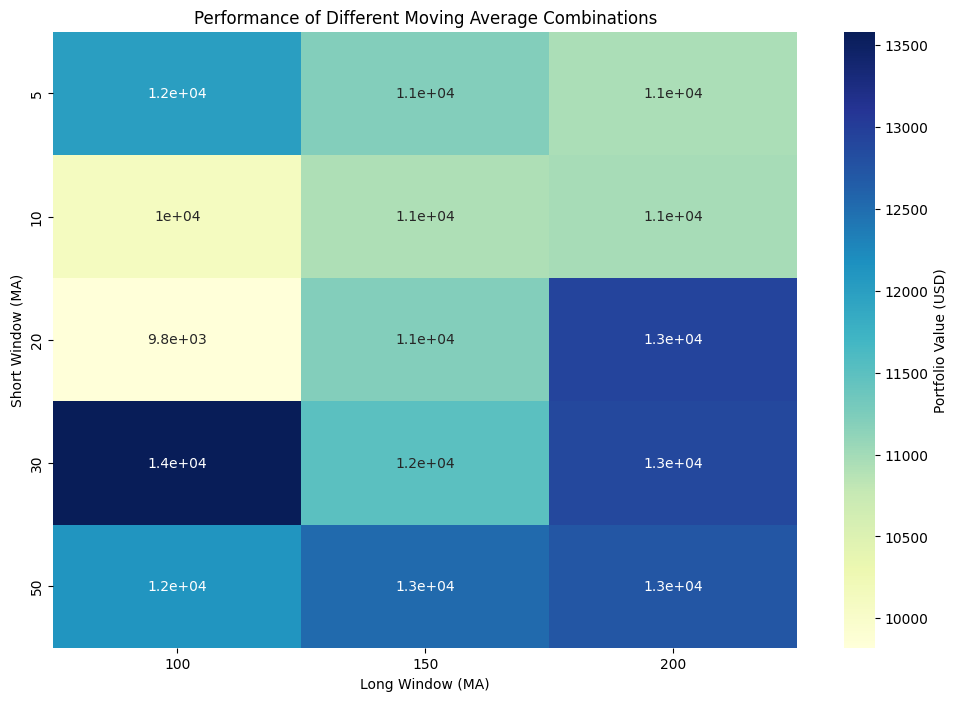

In [48]:
# Plot a heatmap to visualize performance of different MA combinations
plt.figure(figsize=(12, 8))
sns.heatmap(performance.astype(float), annot=True, cmap="YlGnBu", cbar_kws={'label': 'Portfolio Value (USD)'})
plt.title('Performance of Different Moving Average Combinations')
plt.xlabel('Long Window (MA)')
plt.ylabel('Short Window (MA)')
plt.show()


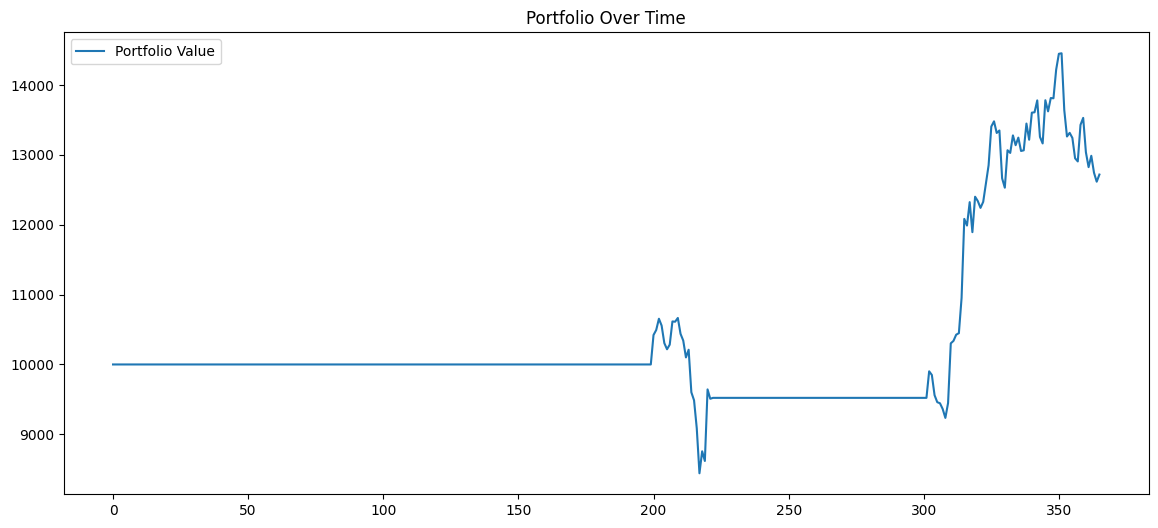

In [49]:
plt.figure(figsize=(14,6))
plt.plot(df['portfolio'], label='Portfolio Value')
plt.title('Portfolio Over Time')
plt.legend()
plt.show()
